# Gradient Boosted Trees Classification Visualization

This notebook visualizes the performance and behavior of our Gradient Boosted Trees implementation.

In [3]:
from google.colab import files

# Upload the zip file from your local machine
uploaded = files.upload()

Saving GradientBoost.zip to GradientBoost.zip


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
import zipfile
import os

# Unzip the uploaded model
with zipfile.ZipFile("GradientBoost.zip", 'r') as zip_ref:
    zip_ref.extractall()

# Verify the file structure
os.listdir("GradientBoost/model")

['GradientBoostedTrees.py', '__init__.py']

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification, make_moons, load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Add your local model path
import sys
sys.path.append('GradientBoost')  # Path to the unzipped folder

# Import your GradientBoostedTrees model
from model.GradientBoostedTrees import GradientBoostedTrees

# Plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

## 1. Generate Datasets for Testing


In [6]:
def generate_datasets():
    X_simple, y_simple = make_classification(n_samples=1000, n_features=2,
                                              n_redundant=0, n_informative=2, random_state=42)
    X_moons, y_moons = make_moons(n_samples=1000, noise=0.3, random_state=42)
    cancer = load_breast_cancer()
    X_cancer, y_cancer = cancer.data, cancer.target

    np.random.seed(42)
    n_samples = 1000
    X1 = np.random.randn(n_samples)
    X2 = np.random.randn(n_samples)
    X3 = 0.8 * X1 + 0.2 * np.random.randn(n_samples)
    X4 = 0.9 * X2 + 0.1 * np.random.randn(n_samples)
    X_collinear = np.column_stack([X1, X2, X3, X4])
    y_collinear = (X1 + X2 > 0).astype(int)

    return {
        'simple': (X_simple, y_simple),
        'moons': (X_moons, y_moons),
        'cancer': (X_cancer, y_cancer),
        'collinear': (X_collinear, y_collinear)
    }

datasets = generate_datasets()

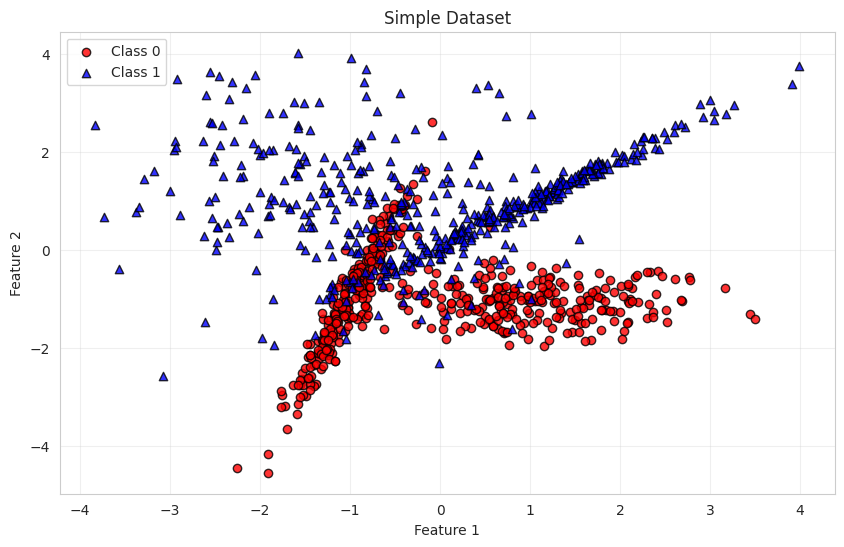

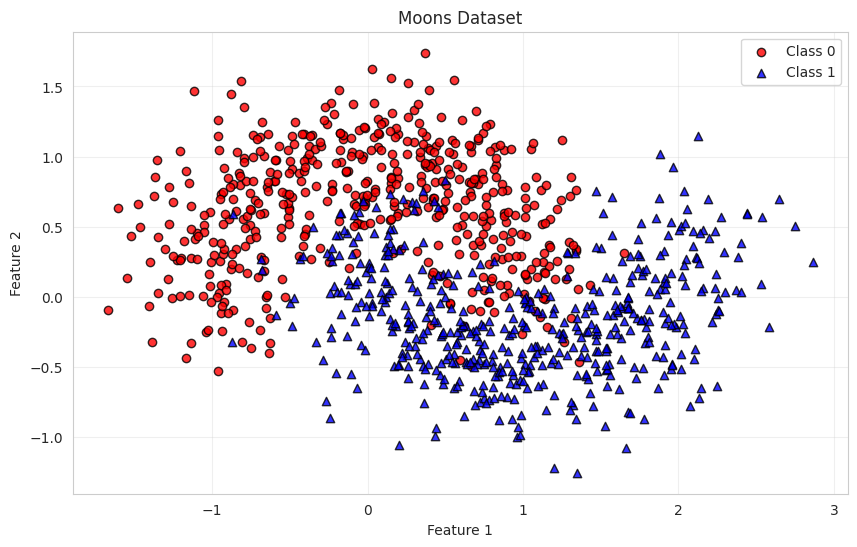

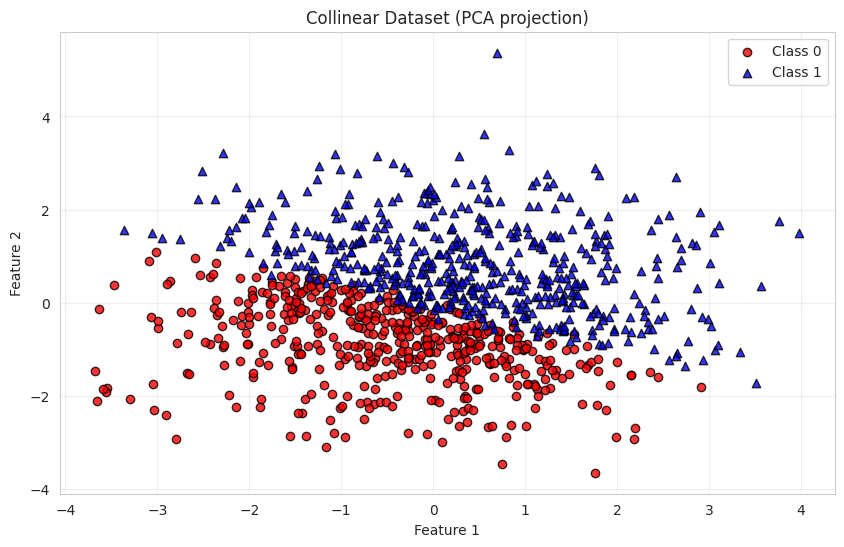

In [7]:
def visualize_dataset(X, y, title):
    plt.figure(figsize=(10, 6))
    if X.shape[1] > 2:
        from sklearn.decomposition import PCA
        pca = PCA(n_components=2)
        X_vis = pca.fit_transform(X)
        plt.title(f"{title} (PCA projection)")
    else:
        X_vis = X
        plt.title(title)

    plt.scatter(X_vis[y == 0, 0], X_vis[y == 0, 1], alpha=0.8, c='red',
                marker='o', label='Class 0', edgecolor='k')
    plt.scatter(X_vis[y == 1, 0], X_vis[y == 1, 1], alpha=0.8, c='blue',
                marker='^', label='Class 1', edgecolor='k')

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

for name, (X, y) in datasets.items():
    if name != 'cancer':
        visualize_dataset(X, y, f"{name.capitalize()} Dataset")

## 3. Train and Evaluate Models on Different Datasets

In [8]:
results = {}

for name, (X, y) in datasets.items():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if name == 'cancer':
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    print(f"Training on {name} dataset...")
    gbt = GradientBoostedTrees(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    gbt.fit(X_train, y_train)

    y_pred = gbt.predict(X_test)
    y_prob = gbt.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    results[name] = {
        'model': gbt,
        'X_test': X_test,
        'y_test': y_test,
        'y_pred': y_pred,
        'y_prob': y_prob,
        'accuracy': accuracy,
        'auc': auc
    }

    print(f"{name.capitalize()} dataset: Accuracy = {accuracy:.4f}, AUC = {auc:.4f}\n")


Training on simple dataset...
Training gradient boosted trees with 100 estimators...
Iteration 1/100, Accuracy: 0.9012
Iteration 10/100, Accuracy: 0.9175
Iteration 20/100, Accuracy: 0.9175
Iteration 30/100, Accuracy: 0.9150
Iteration 40/100, Accuracy: 0.9250
Iteration 50/100, Accuracy: 0.9287
Iteration 60/100, Accuracy: 0.9300
Iteration 70/100, Accuracy: 0.9225
Iteration 80/100, Accuracy: 0.9275
Iteration 90/100, Accuracy: 0.9287
Iteration 100/100, Accuracy: 0.9313
Training completed in 45.51 seconds
Simple dataset: Accuracy = 0.9250, AUC = 0.9794

Training on moons dataset...
Training gradient boosted trees with 100 estimators...
Iteration 1/100, Accuracy: 0.9012
Iteration 10/100, Accuracy: 0.9025
Iteration 20/100, Accuracy: 0.9012
Iteration 30/100, Accuracy: 0.9100
Iteration 40/100, Accuracy: 0.9200
Iteration 50/100, Accuracy: 0.9200
Iteration 60/100, Accuracy: 0.9213
Iteration 70/100, Accuracy: 0.9287
Iteration 80/100, Accuracy: 0.9313
Iteration 90/100, Accuracy: 0.9300
Iteration 10

## 4. Visualize Decision Boundaries

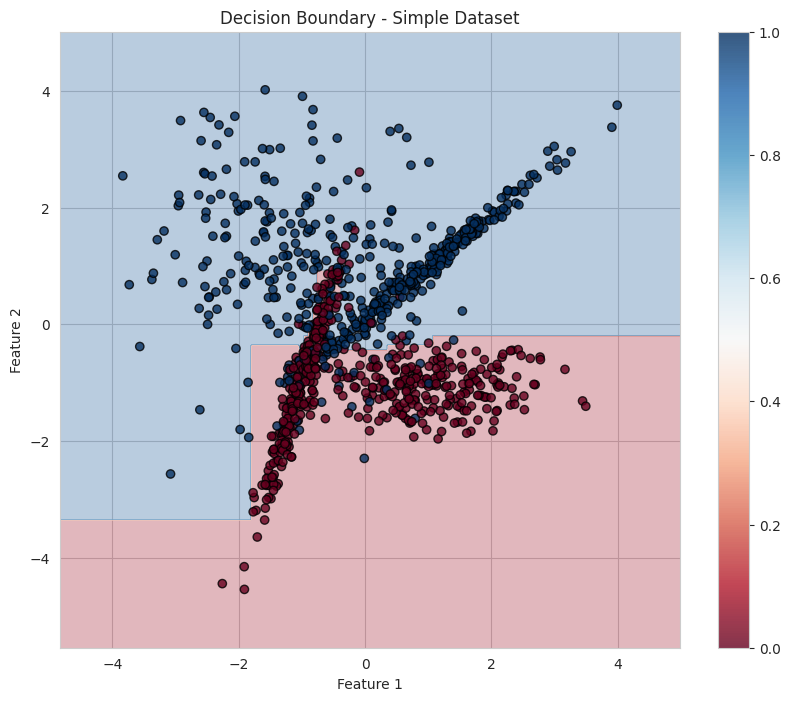

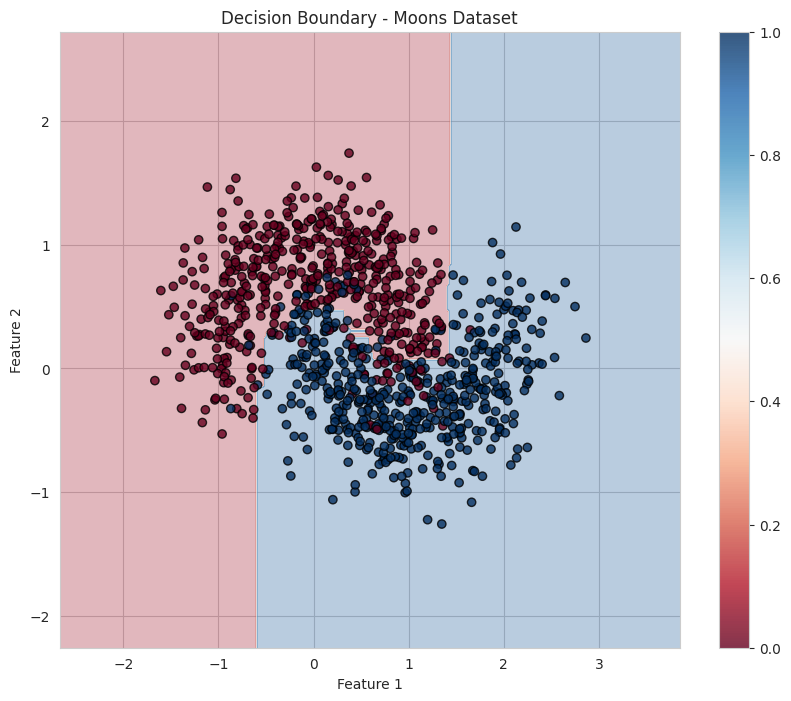

In [9]:
def plot_decision_boundary(model, X, y, title):
    if X.shape[1] != 2:
        print(f"Cannot plot decision boundary for {title} - more than 2 features")
        return

    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdBu)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.RdBu, alpha=0.8)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.colorbar()
    plt.show()

for name in ['simple', 'moons']:
    X, y = datasets[name]
    model = results[name]['model']
    plot_decision_boundary(model, X, y, f"Decision Boundary - {name.capitalize()} Dataset")

## 5. ROC Curves

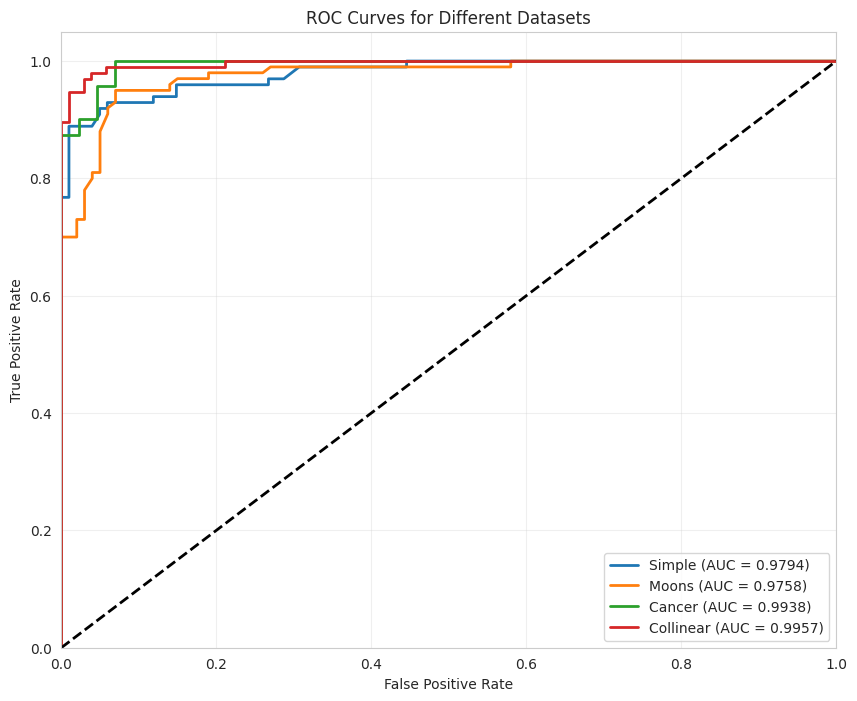

In [10]:
plt.figure(figsize=(10, 8))

for name, data in results.items():
    fpr, tpr, _ = roc_curve(data['y_test'], data['y_prob'])
    auc = data['auc']
    plt.plot(fpr, tpr, lw=2, label=f'{name.capitalize()} (AUC = {auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Datasets')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()


## 6. Confusion Matrices

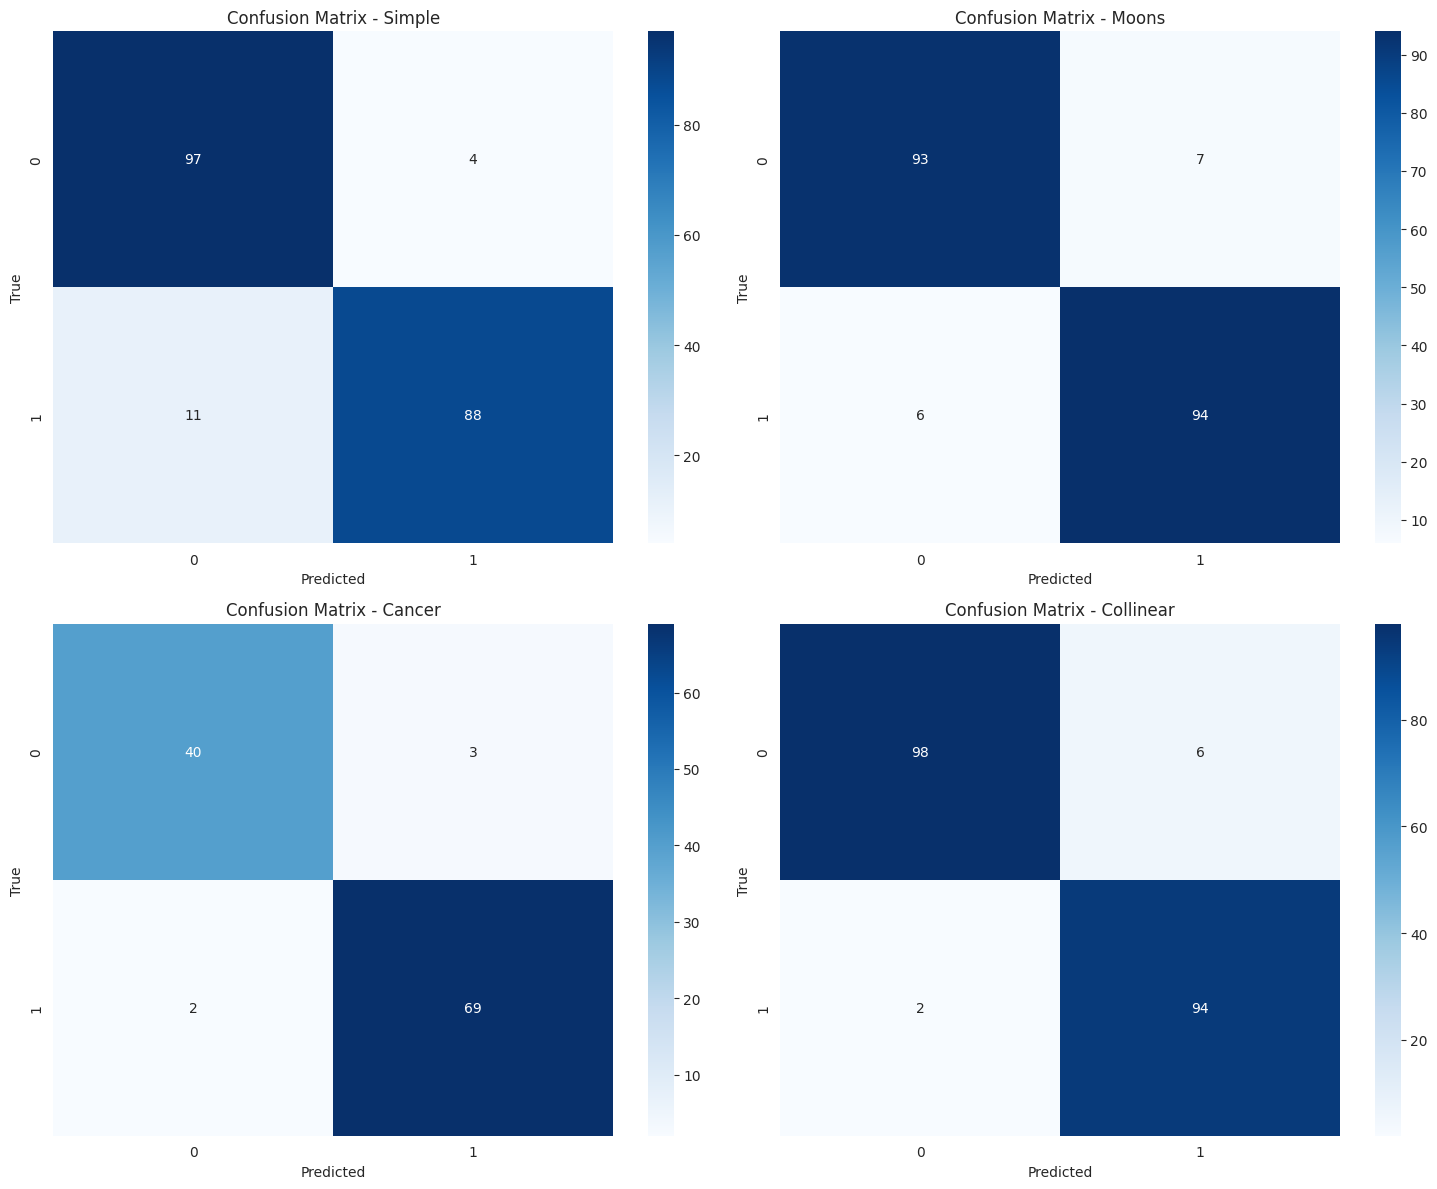

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, (name, data) in enumerate(results.items()):
    cm = confusion_matrix(data['y_test'], data['y_pred'])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {name.capitalize()}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')

plt.tight_layout()
plt.show()


## 7. Learning Rate and Number of Estimators Analysis

In [ ]:
X, y = datasets['moons']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

learning_rates = [0.01, 0.1, 0.5, 1.0]
n_estimators_range = np.arange(10, 210, 10)
results_lr = {}

for lr in learning_rates:
    test_accuracies = []
    for n_est in n_estimators_range:
        gbt = GradientBoostedTrees(n_estimators=n_est, learning_rate=lr, max_depth=3, random_state=42)
        gbt.fit(X_train, y_train)
        y_pred = gbt.predict(X_test)
        test_accuracies.append(accuracy_score(y_test, y_pred))
    results_lr[lr] = test_accuracies

plt.figure(figsize=(12, 8))
for lr, acc in results_lr.items():
    plt.plot(n_estimators_range, acc, label=f'Learning Rate = {lr}')

plt.xlabel('Number of Estimators')
plt.ylabel('Test Accuracy')
plt.title('Effect of Learning Rate and Number of Estimators on Test Accuracy')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


Training gradient boosted trees with 10 estimators...
Iteration 1/10, Accuracy: 0.9012
Iteration 10/10, Accuracy: 0.9012
Training completed in 4.09 seconds
Training gradient boosted trees with 20 estimators...
Iteration 1/20, Accuracy: 0.9012
Iteration 10/20, Accuracy: 0.9012
Iteration 20/20, Accuracy: 0.9012
Training completed in 9.15 seconds
Training gradient boosted trees with 30 estimators...
Iteration 1/30, Accuracy: 0.9012
Iteration 10/30, Accuracy: 0.9012
Iteration 20/30, Accuracy: 0.9012
Iteration 30/30, Accuracy: 0.9012
Training completed in 13.34 seconds
Training gradient boosted trees with 40 estimators...
Iteration 1/40, Accuracy: 0.9012
Iteration 10/40, Accuracy: 0.9012
Iteration 20/40, Accuracy: 0.9012
Iteration 30/40, Accuracy: 0.9012
Iteration 40/40, Accuracy: 0.9012
Training completed in 17.70 seconds
Training gradient boosted trees with 50 estimators...
Iteration 1/50, Accuracy: 0.9012
Iteration 10/50, Accuracy: 0.9012
Iteration 20/50, Accuracy: 0.9012
Iteration 30/50